In [1]:
import operator
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()
import os

## Configure the model

In [2]:
# Set the environment variable for the Groq API key
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

# Import the necessary model from langchain_groq
from langchain_groq import ChatGroq
model = ChatGroq(model_name="deepseek-r1-distill-llama-70b", temperature=0.1)

# from langchain_google_genai import ChatGoogleGenerativeAI
# model=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

output=model.invoke("What is the capital of France?")
print(output.content)

<think>

</think>

The capital of France is Paris.


In [3]:
from langchain.tools import tool

## Custom tools

In [4]:
#
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers.
    Args:
        x (int): The first number.
        y (int): The second number.
    Returns:
        int: The product of x and y.
    """
    return x * y

@tool
def add(x: int, y: int) -> int:
    """Adds two numbers.
    Args:
        x (int): The first number.
        y (int): The second number.
    Returns:
        int: The sum of x and y.
    """
    return x + y

@tool
def divide(x: int, y: int) -> float:
    """Divides two numbers.
    Args:
        x (int): The numerator.
        y (int): The denominator.
    Returns:
        float: The result of x divided by y.
    """
    if y == 0:
        raise ValueError("Cannot divide by zero.")
    return x / y

## importing the inbuilt tools

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
search.invoke("What is the capital of France?")

"Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and attractive cities, famed for its gastronomy, haute couture, painting, literature, and intellectual community. Learn more about Paris in this article. France, a country of northwestern Europe, is historically and culturally among the most important countries in the Western world. It has also played a highly significant role in international affairs for centuries. Its capital is Paris, one of the most important cultural and commercial centers in the world. Paris, the capital of France, is located in the north-central portion of the country. It constitutes one of the départements of the Île-de-France administrative region and is France's most important centre of commerce and culture. The city is home to the Eiffel Tower, one of the world's premier tourist attractions, which opened to the public on May 15, 1889. France: The capital of F

In [6]:
# Define the tools to be used in the graph
tools = [multiply, add, divide, search]

# Bind the tools to the model
llm_with_tools = model.bind_tools(tools)

respone = llm_with_tools.invoke("In which year Tata Group founded?")
print(respone.content)

The Tata Group was founded in the year 1868 by Jamsetji Tata.

Step-by-step explanation:
1. Identify the founder: Jamsetji Tata.
2. Recall historical context: Late 19th century, during the British Raj.
3. Associate with key industries: Steel and motors.
4. Conclude the founding year: 1868.

Answer: 1868


In [7]:
respone.tool_calls

[]

In [ ]:
# Define the system prompt for the LLM
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."

# LLM with tools to handle the first step in the state graph
def function1(state:MessagesState):
    """
    Function to handle the first step in the state graph.
    It takes the current state, retrieves the user question from the messages,
    and invokes the LLM with tools to get a response.
    """    
    # Retrieve the user question from the state messages
    user_question=state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

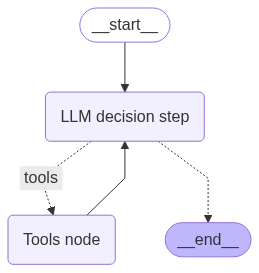

In [14]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Define the state graph
builder = StateGraph(MessagesState)
builder.add_node("LLM decision step", function1)
builder.add_node("Tools node", ToolNode(tools))
builder.add_edge(START, "LLM decision step")
builder.add_conditional_edges("LLM decision step", tools_condition, {"tools": "Tools node", END:END})
builder.add_edge("Tools node", "LLM decision step")
react_graph = builder.compile()

from IPython.display import display, Image
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Example usage of the state graph
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='606c2953-d303-48d6-b455-5e878bb3e778'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wsegxkxhq', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 401, 'prompt_tokens': 415, 'total_tokens': 816, 'completion_time': 1.458181818, 'prompt_time': 0.034414439, 'queue_time': 0.056973522000000006, 'total_time': 1.492596257}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eb6fbe09-ba7d-42ba-a942-2798ce3432b6-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi age'}, 'id': 'wsegxkxhq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 415, 'output_tokens': 401, 'total_tokens': 816}),
  ToolMessage(content='Na

In [ ]:
# Example usage of the state graph with a different question
message = [HumanMessage(content="How much is the net worth of Elon Musk, and divide it by 2?")]
react_graph.invoke({"messages": message})

{'messages': [HumanMessage(content='How much is the net worth of Elon Musk, and divide it by 2?', additional_kwargs={}, response_metadata={}, id='c4385494-10dd-4a3d-b069-f2d5cc8275ad'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wh0mn5pfa', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 451, 'prompt_tokens': 419, 'total_tokens': 870, 'completion_time': 1.765094253, 'prompt_time': 0.033560145, 'queue_time': 0.053308655999999996, 'total_time': 1.798654398}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--967a64e3-a7d5-4ed3-a00f-eb9dcc717548-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'wh0mn5pfa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 419, 'output_tokens': 451, 'total_tokens

In [18]:
# Example usage of the state graph with a search query
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]
react_graph.invoke({"messages": message})

{'messages': [HumanMessage(content='What is the speed of light in m/s and multiply it by 10?', additional_kwargs={}, response_metadata={}, id='e8e2c2d0-7feb-493c-988a-7160d0ea922c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4yn81h1xt', 'function': {'arguments': '{"x":299792458,"y":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 395, 'prompt_tokens': 418, 'total_tokens': 813, 'completion_time': 1.5580688729999999, 'prompt_time': 0.034520678, 'queue_time': 0.057061350999999996, 'total_time': 1.592589551}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--95444c54-81c3-4683-b636-c06010886f19-0', tool_calls=[{'name': 'multiply', 'args': {'x': 299792458, 'y': 10}, 'id': '4yn81h1xt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 418, 'output_tokens': 395, 'total_tokens': 813}),
  ToolMessage(content='2997924

In [19]:
# Streaming the response from the state graph
for output in react_graph.stream({"messages":["What is the speed of light in m/s and multiply it by 10?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")
    

here is output from LLM decision step
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7g4eswc38', 'function': {'arguments': '{"x":299792458,"y":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 391, 'prompt_tokens': 418, 'total_tokens': 809, 'completion_time': 1.421818182, 'prompt_time': 0.026797715, 'queue_time': 0.054295258, 'total_time': 1.448615897}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1b23fa09-d237-4600-86b0-b99d0fb13f8a-0', tool_calls=[{'name': 'multiply', 'args': {'x': 299792458, 'y': 10}, 'id': '7g4eswc38', 'type': 'tool_call'}], usage_metadata={'input_tokens': 418, 'output_tokens': 391, 'total_tokens': 809})]}


here is output from Tools node
_______
{'messages': [ToolMessage(content='2997924580', name='multiply', id='097b8da2-4a71-436d-ae10-e371df83ea38', tool_call_id='7g4eswc

In [23]:
# printing the final response using pretty print
for event in react_graph.invoke({"messages": message})['messages']:
    event.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (jp5hqy3as)
 Call ID: jp5hqy3as
  Args:
    x: 299792458
    y: 10
================================= Tool Message =================================
Name: multiply

2997924580
================================== Ai Message ==================================

The speed of light is approximately **299,792,458 m/s**. When multiplied by 10, the result is **2,997,924,580**.


## Add financial tool to fetch stock prices


In [ ]:
import yfinance as yf

# Define a tool to fetch stock prices using yfinance
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

# get stock price for Apple Inc.
print(get_stock_price.invoke("AAPL"))

# get stock price for Tesla Inc.
print(get_stock_price.invoke("TSLA"))

# get stock price for Nifty 50
print(get_stock_price.invoke("NIFTY50.BO"))

# Add the new tool to the list of tools
tools = [add, multiply, divide, search,get_stock_price]
# Bind the tools to the model again
llm_with_tools = model.bind_tools(tools)
# Invoke the LLM with tools to get the stock price of Adani Greens
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")
print(response.content)
# Note: after invoking the LLM with tools, you can access the tool calls from the response. however until 
# we don't design the state graph to handle the new tool, it won't show any output.

# Access the tool calls from the response
response.tool_calls



The last closing price of AAPL was $199.20.
The last closing price of TSLA was $319.11.


HTTP Error 404: 


Could not fetch price for ticker 'NIFTY50.BO'.



[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.NS'},
  'id': 'e2j4p5cbn',
  'type': 'tool_call'}]

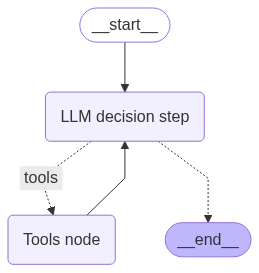

In [ ]:
# Redesign the state graph to include the new stock price tool
# Define the system prompt for the LLM
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
# LLM with tools to handle the first step in the state graph
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

# Define the state graph
builder1 = StateGraph(MessagesState)
builder1.add_node("LLM decision step", function1)
builder1.add_node("Tools node", ToolNode(tools))
builder1.add_edge(START, "LLM decision step")
builder1.add_conditional_edges("LLM decision step", tools_condition, {"tools": "Tools node", END:END})
builder1.add_edge("Tools node", "LLM decision step")
react_graph1 = builder1.compile()

from IPython.display import display, Image
display(Image(react_graph1.get_graph().draw_mermaid_png()))

In [39]:
# Example usage of the redesigned state graph with the stock price tool
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph1.invoke({"messages": messages})

# printing the final response using pretty print
for event in messages['messages']:
    event.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (p195s4zmt)
 Call ID: p195s4zmt
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (6845mec5q)
 Call ID: 6845mec5q
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================

The result of adding 1000 to the current stock price of Apple is **1199.20**.
